In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils
import tensorflow as tf
import numpy as np
import time
from keras.datasets import cifar10
from keras.utils import np_utils
import scipy.sparse
%matplotlib inline


Using TensorFlow backend.


In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 8, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 4, 'Number of coarsened graphs.')

# Directories.
flags.DEFINE_string('dir_data', os.path.join('..', 'data', 'mnist'), 'Directory to store data.')

# Feature graph

4166 > 4096 edges
Execution time: 0.30s
[matrix([[ 0.        , -0.15267725, -0.0954518 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.15267725,  0.        , -0.14974779, ...,  0.        ,
          0.        ,  0.        ],
        [-0.0954518 , -0.1497478 ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.14974946],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.14974946,  0.        ]], dtype=float32), matrix([[ 0.        , -0.18835647,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.18835647,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..

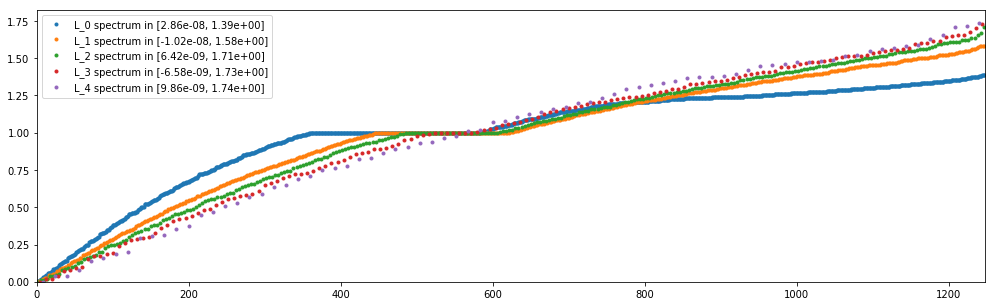

In [3]:
def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=FLAGS.number_edges, metric=FLAGS.metric)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))

    print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*m**2//2))
    return A

t_start = time.process_time()
A = grid_graph(32, corners=False)
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)

L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
graph.plot_spectrum(L)
L = [A.toarray() for A in L]
L = [graph.rescale_L(A) for A in L]
print(L, L[0].shape)
#del A


# Data

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2],X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2],X_test.shape[3])
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

rand_perm = np.random.permutation(X_train.shape[0])
r = 45000

train_data = X_train[rand_perm[0:r],:,:]
val_data = X_train[rand_perm[r:],:,:]
test_data = X_test
train_labels = np_utils.to_categorical(y_train[rand_perm[0:r]])
val_labels = np_utils.to_categorical(y_train[rand_perm[r:]])
test_labels = np_utils.to_categorical(y_test)

#train_data = X_train[rand_perm[0:r],:,0]
#val_data = X_train[rand_perm[r:],:,0]
#test_data = X_test[:,:,0]

print(len(perm))
print(train_data.shape, test_data.shape, val_data.shape)
t_start = time.process_time()
train_data = coarsening.perm_data(train_data, perm)
val_data = coarsening.perm_data(val_data, perm)
test_data = coarsening.perm_data(test_data, perm)
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#del perm,X_train,X_test

L = np.array(L)
single_laplacian =  np.array([q for q in L])
#print(single_laplacian)
train_laplacians = []
for j in range(L.shape[0]):
    train_laplacians.append([single_laplacian[j] for i in range(45000)])                        
val_laplacians = []
for j in range(L.shape[0]):
    val_laplacians.append([single_laplacian[j] for i in range(10000)])
test_laplacians = []
for j in range(L.shape[0]):
    test_laplacians.append([single_laplacian[j] for i in range(5000)])

#print(len(train_laplacians))
#for i in range(len(train_laplacians)):
#    print(len(train_laplacians[i]))

1248
(45000, 1024, 3) (10000, 1024, 3) (5000, 1024, 3)
Execution time: 6.36s


# Neural networks

In [5]:
common = {}
common['dir_name']       = 'cifar10/'
common['num_epochs']     = 2
common['batch_size']     = 100
common['decay_steps']    = (train_data.shape[0] + val_data.shape[0]) / common['batch_size']
common['eval_frequency'] = 30 * common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = train_labels.shape[1]  # number of classes
model_perf = utils.model_perf()

In [7]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 5e-4
    params['dropout']        = 1
    params['learning_rate']  = 0.02
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['F_0']            = 3
    params['K']              = []
    params['p']              = []
    params['M']              = [C]
    params['train_laplacians'] = train_laplacians
    params['test_laplacians'] = val_laplacians
    params['val_laplacians'] = test_laplacians
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels , test_data, test_labels)

NN architecture
  input: M_0 = 1248
  layer 1: logits (softmax)
    representation: M_1 = 10
    weights: M_0 * M_1 = 1248 * 10 = 12480
    biases: M_1 = 10


InternalError: Blas SGEMM launch failed : a.shape=(100, 3744), b.shape=(3744, 10), m=100, n=10, k=3744
	 [[Node: logits/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](Reshape, logits/weights/read)]]
	 [[Node: training/control/_31 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_350_training/control", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'logits/MatMul', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/halwai/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/halwai/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/halwai/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/halwai/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/halwai/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/halwai/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/halwai/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/halwai/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/halwai/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/halwai/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/halwai/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/halwai/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/halwai/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/halwai/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/halwai/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/halwai/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/halwai/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/halwai/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-ae1078812d45>", line 18, in <module>
    model_perf.test(models.cgcnn(L, **params), name, params,
  File "../lib/models.py", line 896, in __init__
    self.build_graph(M_0, F_0, M[-1], L)
  File "../lib/models.py", line 228, in build_graph
    op_logits = self.inference(self.ph_data, self.ph_laplacians ,self.ph_dropout)
  File "../lib/models.py", line 257, in inference
    logits = self._inference(data, laplacians, dropout)
  File "../lib/models.py", line 1079, in _inference
    x = self.fc(x, self.M[-1], relu=False)
  File "../lib/models.py", line 1051, in fc
    x = tf.matmul(x, W) + b
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_ops.py", line 1765, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 1454, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InternalError (see above for traceback): Blas SGEMM launch failed : a.shape=(100, 3744), b.shape=(3744, 10), m=100, n=10, k=3744
	 [[Node: logits/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](Reshape, logits/weights/read)]]
	 [[Node: training/control/_31 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_350_training/control", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [25]:
# Common hyper-parameters for networks with one convolutional layer.
common['regularization'] = 0
common['dropout']        = 1
common['learning_rate']  = 0.02
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [10]
common['F_0']             = 3
common['K']              = [20]
common['p']              = [1]
common['M']              = [C]
common['train_laplacians'] = train_laplacians
common['test_laplacians'] = val_laplacians
common['val_laplacians'] = test_laplacians

In [40]:
# Common hyper-parameters for LeNet5-like networks.
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.02  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [32, 64]
common['F_0']            = 3
common['K']              = [25, 25]
common['p']              = [4, 4]
common['M']              = [512, C]
common['train_laplacians'] = train_laplacians
common['test_laplacians'] = val_laplacians
common['val_laplacians'] = test_laplacians

In [ ]:
if True:
    name = 'cgconv_cgconv_fc_softmax'  # 'Chebyshev'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1312
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1312 * 32 / 4 = 10496
    weights: F_0 * F_1 * K_1 = 3 * 32 * 25 = 2400
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 328 * 64 / 4 = 5248
    weights: F_1 * F_2 * K_2 = 32 * 64 * 25 = 51200
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 5248 * 512 = 2686976
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 10
    weights: M_3 * M_4 = 512 * 10 = 5120
    biases: M_4 = 10
0 th conv layer 100 1312 1312
1 th conv layer 100 328 328
  learning_rate = 2.00e-02, loss_average = 2.40e+00
  learning_rate = 2.00e-02, loss_average = 1.38e+01
  learning_rate = 2.00e-02, loss_average = 2.71e+01
  learning_rate = 2.00e-02, loss_average = 2.80e+01
  learning_rate = 2.00e-02, loss_average = 2.67e+01
  learning_rate = 2.00e-02, loss_average = 2.53e+01
  learning_rate = 2.00e-02, loss_average = 2.40e+01
  learning

In [ ]:
model_perf.show()

In [ ]:
if False:
    grid_params = {}
    data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
    utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))